In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(112, 35)


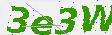

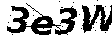

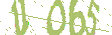

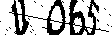

In [3]:
from captchagen import get_captcha_image, generate_captcha, preprocess_image

# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display

display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
import torch
from models.cnn import CaptchaOCR

model = CaptchaOCR().to(device)
import os

if os.path.exists("captcha_ocr.pth"):
    model.load_state_dict(torch.load("captcha_ocr.pth"))

/tmp/ipykernel_1056577/1488443610.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("captcha_ocr.pth"))


In [3]:
from models.transformer import CaptchaSolverWithTransformer

model = CaptchaSolverWithTransformer().to(device)
import os

if os.path.exists("captcha_transformer.pth"):
    model.load_state_dict(torch.load("captcha_transformer.pth"))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1203494/4085151542.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed t

In [13]:
from models.cnn_transformer import CaptchaSolverWithCNNTransformer

model = CaptchaSolverWithCNNTransformer().to(device)
import os

# if os.path.exists("captcha_cnn_transformer.pth"):
#     model.load_state_dict(torch.load("captcha_cnn_transformer.pth"))

/home/cao/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
from models.resnet import ResNetCaptchaOCR

model = ResNetCaptchaOCR().to(device)
import os

if os.path.exists("captcha_resnet.pth"):
    model.load_state_dict(torch.load("captcha_resnet.pth"))

In [5]:
# save model
def save_model(model):
    if model.__class__.__name__ == "CaptchaOCR":
        torch.save(model.state_dict(), "captcha_ocr.pth")
    elif model.__class__.__name__ == "CaptchaSolverWithTransformer":
        torch.save(model.state_dict(), "captcha_transformer.pth")
    elif model.__class__.__name__ == "ResNetCaptchaOCR":
        torch.save(model.state_dict(), "captcha_resnet.pth")

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f"runs/{model.__class__.__name__}")
last_epoch = 223

In [6]:
from torch.utils.data import DataLoader
from dataset import CaptchaDataset

dataset = CaptchaDataset("train", 100000, repeat=8)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = CaptchaDataset("test", 256)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

100%|██████████| 256/256 [00:00<00:00, 1154.59it/s]


In [10]:
# train model
import torch
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(last_epoch, 100 + last_epoch):
    last_epoch = epoch
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f"epoch: {epoch}, loss: {loss.item()}, accuracy: {accuracy.item()}")

    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            total_loss += criterion(
                y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)
            ).item()
            total_accuracy += (
                (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
            )
        total_loss /= len(test_dataloader)
        tqdm.write(
            f"test loss: {total_loss}, test accuracy: {total_accuracy / len(test_dataloader)}"
        )
    writer.add_scalars("loss", {"train": loss.item(), "test": total_loss}, epoch)
    writer.add_scalars(
        "accuracy",
        {"train": accuracy.item(), "test": total_accuracy / len(test_dataloader)},
        epoch,
    )
    save_model(model)

100%|██████████| 3125/3125 [00:57<00:00, 54.44it/s]


epoch: 248, loss: 1.8906292915344238, accuracy: 0.6953125
test loss: 1.9846968054771423, test accuracy: 0.66015625


100%|██████████| 3125/3125 [00:57<00:00, 54.40it/s]


epoch: 249, loss: 1.753136157989502, accuracy: 0.7421875
test loss: 2.008413553237915, test accuracy: 0.6455078125


100%|██████████| 3125/3125 [00:57<00:00, 54.79it/s]


epoch: 250, loss: 1.896270513534546, accuracy: 0.6875
test loss: 2.007004499435425, test accuracy: 0.6396484375


100%|██████████| 3125/3125 [00:57<00:00, 54.77it/s]


epoch: 251, loss: 1.648411512374878, accuracy: 0.8125
test loss: 2.0281544625759125, test accuracy: 0.6337890625


100%|██████████| 3125/3125 [00:57<00:00, 54.79it/s]


epoch: 252, loss: 1.723140001296997, accuracy: 0.78125
test loss: 2.0234700441360474, test accuracy: 0.634765625


100%|██████████| 3125/3125 [00:57<00:00, 54.76it/s]


epoch: 253, loss: 1.729459524154663, accuracy: 0.734375
test loss: 2.035485029220581, test accuracy: 0.6318359375


100%|██████████| 3125/3125 [00:56<00:00, 54.86it/s]


epoch: 254, loss: 1.7420740127563477, accuracy: 0.7578125
test loss: 1.985599935054779, test accuracy: 0.6767578125


100%|██████████| 3125/3125 [00:57<00:00, 54.42it/s]


epoch: 255, loss: 1.6261446475982666, accuracy: 0.796875
test loss: 2.018490195274353, test accuracy: 0.61328125


100%|██████████| 3125/3125 [00:54<00:00, 57.27it/s]


epoch: 256, loss: 1.8385322093963623, accuracy: 0.7265625
test loss: 2.0040374100208282, test accuracy: 0.6591796875


100%|██████████| 3125/3125 [00:55<00:00, 56.06it/s]


epoch: 257, loss: 1.6072371006011963, accuracy: 0.7734375
test loss: 2.0248199701309204, test accuracy: 0.6416015625


100%|██████████| 3125/3125 [00:55<00:00, 56.36it/s]


epoch: 258, loss: 1.8274543285369873, accuracy: 0.7109375
test loss: 2.062656342983246, test accuracy: 0.6240234375


100%|██████████| 3125/3125 [00:55<00:00, 56.67it/s]


epoch: 259, loss: 1.5813043117523193, accuracy: 0.7890625
test loss: 2.069050580263138, test accuracy: 0.634765625


100%|██████████| 3125/3125 [00:55<00:00, 55.93it/s]


epoch: 260, loss: 1.7236326932907104, accuracy: 0.78125
test loss: 1.9849032163619995, test accuracy: 0.6474609375


100%|██████████| 3125/3125 [00:56<00:00, 54.95it/s]


epoch: 261, loss: 1.9254136085510254, accuracy: 0.6328125
test loss: 2.104097306728363, test accuracy: 0.6083984375


100%|██████████| 3125/3125 [00:56<00:00, 54.84it/s]


epoch: 262, loss: 1.5999810695648193, accuracy: 0.75
test loss: 2.057420015335083, test accuracy: 0.6318359375


100%|██████████| 3125/3125 [00:57<00:00, 54.78it/s]


epoch: 263, loss: 1.7615869045257568, accuracy: 0.765625
test loss: 2.0424691438674927, test accuracy: 0.6298828125


100%|██████████| 3125/3125 [00:57<00:00, 54.70it/s]


epoch: 264, loss: 1.7428150177001953, accuracy: 0.7265625
test loss: 2.010167807340622, test accuracy: 0.669921875


100%|██████████| 3125/3125 [00:57<00:00, 54.73it/s]


epoch: 265, loss: 1.8447372913360596, accuracy: 0.6484375
test loss: 2.0329949259757996, test accuracy: 0.65234375


 36%|███▌      | 1129/3125 [00:20<00:36, 54.85it/s]


KeyboardInterrupt: 

In [30]:
# eval model
from dataset import CaptchaDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataset = CaptchaDataset(1000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

with torch.no_grad():
    total_loss = 0
    total_accuracy = 0
    for x, y in tqdm(test_dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        total_loss += criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)).item()
        total_accuracy += (
            (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
        )
    total_loss /= len(test_dataloader)
    print(
        f"Loss: {total_loss/len(test_dataloader)} Accuracy: {total_accuracy/len(test_dataloader)}"
    )

100%|██████████| 31/31 [00:00<00:00, 718.47it/s]

Loss: 0.030414240355298126 Accuracy: 0.7046370967741935


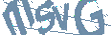

mSvG


[('msV9', 0.020603202283382416),
 ('msVG', 0.01988968253135681),
 ('msVm', 0.01813456229865551),
 ('msVy', 0.016691921278834343),
 ('msVH', 0.014757568016648293),
 ('msV1', 0.013921716250479221),
 ('mGV9', 0.01017177663743496),
 ('mGVG', 0.0098195131868124),
 ('mGVm', 0.008953012526035309),
 ('msVz', 0.00861145369708538)]

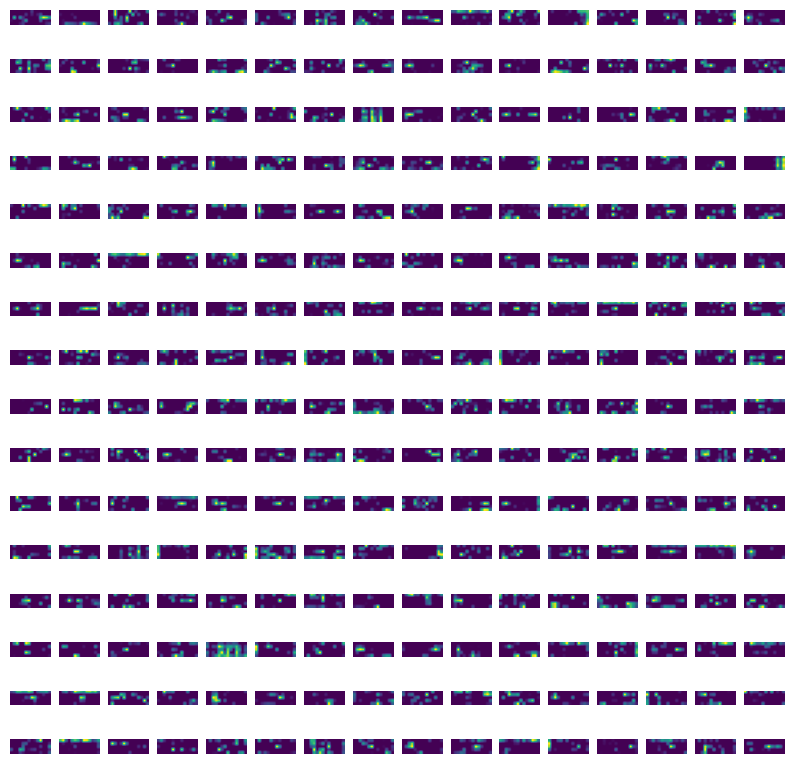

In [34]:
from captchagen import generate_captcha, preprocess_image
from torchvision import transforms


# show middle output of model
def hook_fn(m, i, o):
    global output
    output = o


hook = model.res_layers[3].register_forward_hook(hook_fn)

# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
display(y_pred)

# get res_layers output
hook.remove()
output = output.squeeze(0)

import matplotlib.pyplot as plt


def plot_res_layers_output(output):
    num_channels = output.size(0)
    grid_size = int(num_channels**0.5)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_channels:
            ax.imshow(output[i].detach().cpu().numpy(), cmap="viridis")
        ax.axis("off")
    plt.show()


plot_res_layers_output(output)

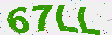

[('JIcC', 0.006978987716138363),
 ('JjcC', 0.006480333860963583),
 ('eIcC', 0.005424936302006245),
 ('ejcC', 0.00503732031211257),
 ('JlcC', 0.004326726775616407),
 ('6IcC', 0.003703877329826355),
 ('JIDC', 0.003544747829437256),
 ('6jcC', 0.0034392320085316896),
 ('elcC', 0.0033632696140557528),
 ('JjDC', 0.0032914727926254272)]

In [28]:
from captchagen import get_captcha_image

# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
y_pred